# Natural Language Processing - Coursework
Antoine EDY

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
import math
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")

In [2]:
import utils

In [3]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [4]:
BiLSTMTagger = utils.BiLSTMTagger

def bilstm_pipeline(datasets, embeddings='glove', totrain=False):
    train_dataset = pd.DataFrame(datasets['train'])
    test_dataset = pd.DataFrame(datasets['test'])
    val_dataset = pd.DataFrame(datasets['validation'])

    train_dataset = utils.preprocess(train_dataset)
    test_dataset = utils.preprocess(test_dataset)
    val_dataset = utils.preprocess(val_dataset)
    BATCH_SIZE = 16
    train_iter, val_iter, test_iter, text_field, label_field, VOCAB_SIZE = utils.init_data(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE)
    embedding_matrix = utils.load_embeddings(embeddings, text_field)
    print(f"Emebdding matrix shape: {embedding_matrix.shape}")
    NUM_CLASSES = len(label_field.vocab)
    print(f"Number of classes: {NUM_CLASSES} ({label_field.vocab.itos})")

    EMBEDDING_DIM = 300
    HIDDEN_DIM = 256
    MAX_EPOCHS = 50
    PATIENCE = 50
    OUTPUT_PATH = "model_saves/bilstmtagger"
    num_batches = math.ceil(len(train_dataset) / BATCH_SIZE)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #BiLSTMTagger = utils.BiLSTMTagger
    tagger = utils.BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)

    if totrain:
        train_f, dev_f = utils.train(BiLSTMTagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, num_batches, PATIENCE, OUTPUT_PATH, label_field=label_field)

    return label_field, test_iter, BATCH_SIZE


In [5]:
def transformer_pipeline(dataset, model_checkpoint):
    tokenizer, data_collator, tokenized_datasets, model_checkpoint, label_list, batch_size = utils.initiate_transformer_data(dataset, model_checkpoint)
    trainer, model, tokenized_datasets, metric = utils.initiate_training(data_collator, tokenized_datasets, model_checkpoint, label_list, batch_size, dataset, tokenizer)
    eval = utils.evaluate_transformer(tokenized_datasets, trainer, label_list, metric)

## 1. Data visualization 

In [38]:
import scienceplots
plt.style.use(['science'])
plt.rcParams['text.usetex'] = True
train_dataset = pd.DataFrame(dataset['train'])
test_dataset = pd.DataFrame(dataset['test'])
val_dataset = pd.DataFrame(dataset['validation'])

Text(0, 0.5, 'Density')

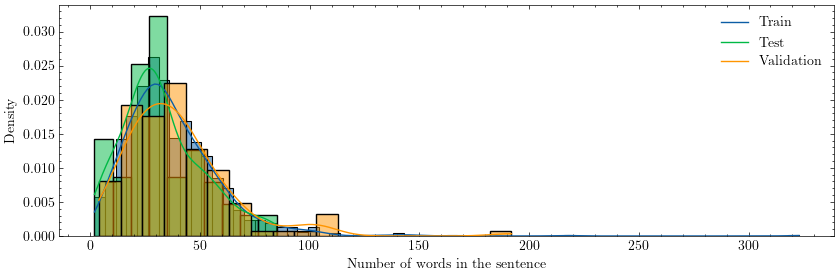

In [41]:
train_dataset['length'] = train_dataset['tokens'].apply(len)
test_dataset['length'] = test_dataset['tokens'].apply(len)
val_dataset['length'] = val_dataset['tokens'].apply(len)

plt.figure(figsize=(10, 3))



sns.histplot(train_dataset['length'], kde=True, stat='density')
sns.histplot(test_dataset['length'], kde=True, stat='density')
sns.histplot(val_dataset['length'], kde=True, stat='density')
plt.legend(['Train', 'Test', 'Validation'])
plt.xlabel('Number of words in the sentence')
plt.ylabel('Density')

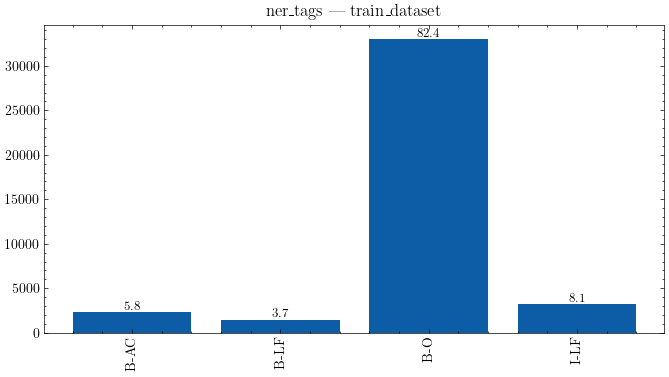

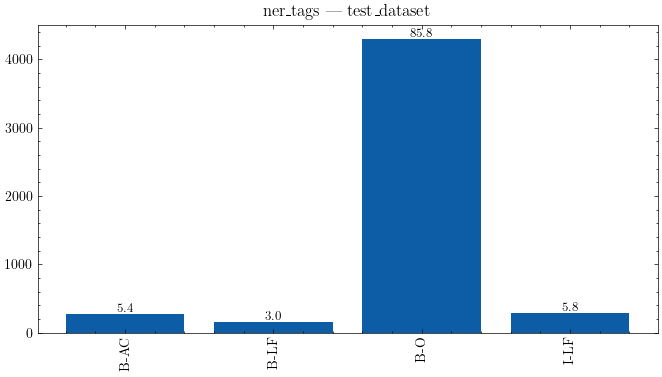

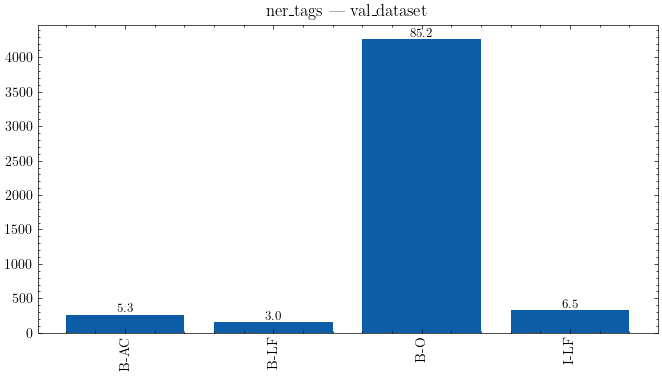

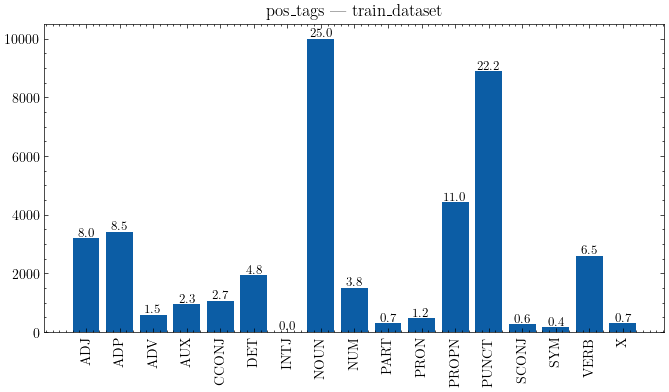

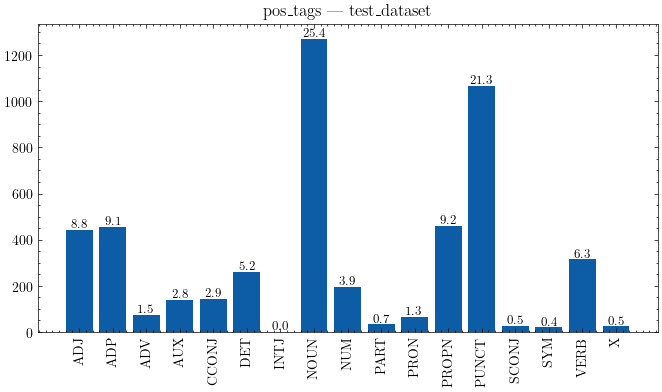

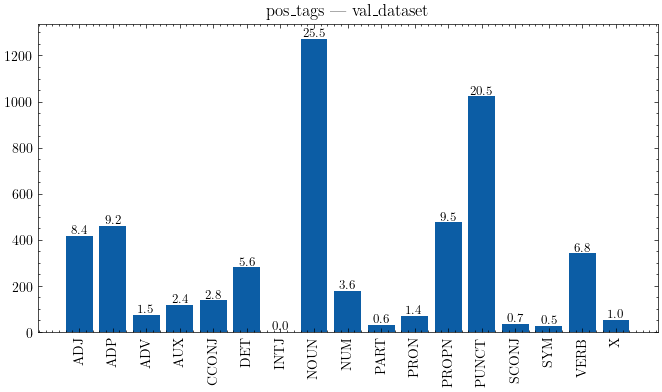

In [42]:
def namestr(obj, namespace=globals()):
    return [name for name in namespace if namespace[name] is obj]

tags_pos = set()
for tags_list in train_dataset['pos_tags']:
    tags_pos.update(tags_list)
tags_pos = sorted(list(tags_pos))

tags_ner = set()
for tags_list in train_dataset['ner_tags']:
    tags_ner.update(tags_list)
tags_ner = sorted(list(tags_ner))

def tags_count(dataset, tag = 'pos_tags'):
    total_len = sum(dataset['length'])
    if tag == 'pos_tags':
        thetags = tags_pos
    else:
        thetags = tags_ner
    tags_count = {tag: 0 for tag in thetags}
    for tags_list in dataset[tag]:
        for _tag in tags_list:
            tags_count[_tag] += 1
    plt.figure(figsize=(8, 4))
    plt.bar(tags_count.keys(), tags_count.values())
    for i in range(len(tags_count)):
        plt.text(i, list(tags_count.values())[i], str(round(list(tags_count.values())[i]/total_len*100, 1)) + '%', ha = 'center', va = 'bottom', fontsize=9)
    plt.xticks(rotation=90)
    plt.title(tag + ' | ' + namestr(dataset)[0])
    plt.show()

tags_count(train_dataset, 'ner_tags')
tags_count(test_dataset, 'ner_tags')
tags_count(val_dataset, 'ner_tags')

tags_count(train_dataset, 'pos_tags')
tags_count(test_dataset, 'pos_tags')
tags_count(val_dataset, 'pos_tags')

## 2. Experiments

### 2.1 Data Preprocessing

In [6]:
def the_preprocess(df, lowercase = False, lematize = False, stemming = False):
    df = pd.DataFrame(df)

    if lowercase:
        df["tokens"] = df["tokens"].apply(lambda x: [i.lower() for i in x])
    if lematize:
        lematizer = nltk.WordNetLemmatizer()
        df["tokens"] = df["tokens"].apply(lambda x: [lematizer.lemmatize(i) for i in x])
    if stemming:
        stemmer = nltk.PorterStemmer()
        df["tokens"] = df["tokens"].apply(lambda x: [stemmer.stem(i) for i in x])

    return df

#### No preprocessing

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.56      0.68      0.62       270
        I-LF       0.68      0.75      0.71       288
        B-LF       0.59      0.57      0.58       150
         B-O       0.96      0.94      0.95      4292

    accuracy                           0.91      5000
   macro avg       0.70      0.74      0.72      5000
weighted avg       0.91      0.91      0.91      5000



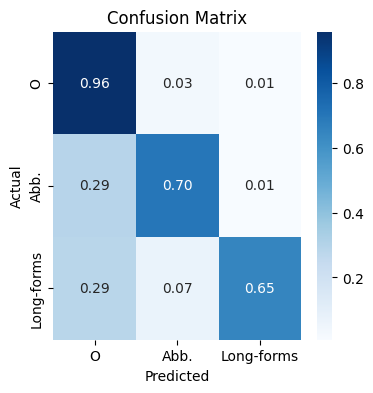

In [7]:
train_dataset = the_preprocess(dataset["train"])
test_dataset = the_preprocess(dataset["test"])
val_dataset = the_preprocess(dataset["validation"])

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/nopreprocess"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

#### Lowercase

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.55      0.66      0.60       270
        I-LF       0.65      0.80      0.72       288
        B-LF       0.53      0.61      0.57       150
         B-O       0.96      0.93      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.67      0.75      0.71      5000
weighted avg       0.91      0.90      0.90      5000



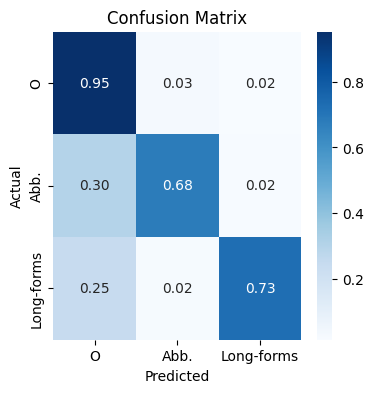

In [8]:
train_dataset = the_preprocess(dataset["train"], lowercase=True)
test_dataset = the_preprocess(dataset["test"], lowercase=True)
val_dataset = the_preprocess(dataset["validation"], lowercase=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/lowercase"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

#### Stemming

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.52      0.68      0.59       270
        I-LF       0.58      0.83      0.69       288
        B-LF       0.53      0.65      0.58       150
         B-O       0.97      0.91      0.94      4292

    accuracy                           0.89      5000
   macro avg       0.65      0.77      0.70      5000
weighted avg       0.91      0.89      0.89      5000



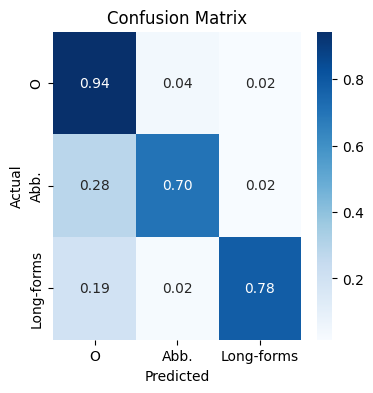

In [9]:
train_dataset = the_preprocess(dataset["train"], stemming=True)
test_dataset = the_preprocess(dataset["test"], stemming=True)
val_dataset = the_preprocess(dataset["validation"], stemming=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/stemming"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

#### Lemmatization

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.54      0.70      0.61       270
        I-LF       0.64      0.85      0.73       288
        B-LF       0.51      0.64      0.57       150
         B-O       0.97      0.92      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.66      0.78      0.71      5000
weighted avg       0.92      0.90      0.90      5000



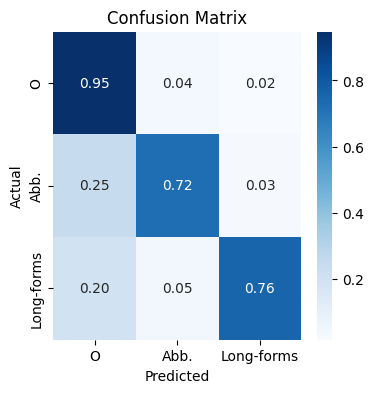

In [10]:
train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/fasttext_lem"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


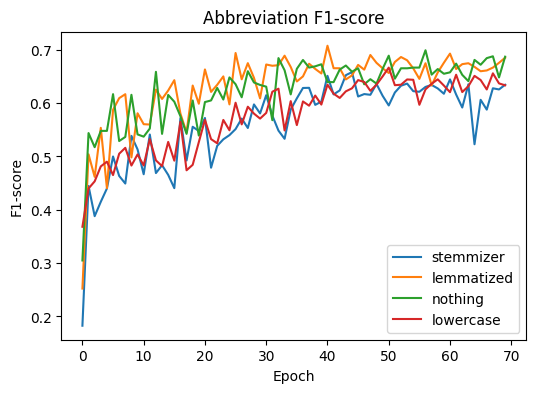

,Model,Abb. Precision,Abb. Recall,Abb. F1-score,LF Precision,LF Recall,LF F1-score,Weighted Avg F1-score
0,stemmizer,0.620,0.650,0.635,0.547,0.544,0.545,0.904
1,lemmatized,0.715,0.658,0.685,0.567,0.570,0.569,0.911
2,nothing,0.743,0.639,0.687,0.590,0.530,0.558,0.907
3,lowercase,0.595,0.677,0.633,0.617,0.530,0.570,0.908


In [11]:
tb_df = utils.from_tensorboard('tensorboard_runs/preprocessing', isString=True)
tb_df.head()

### 2.2 Model architecture

#### Stanford deidentifier base

  0%|          | 0/8 [00:00<?, ?it/s]

<Figure size 3840x2880 with 0 Axes>

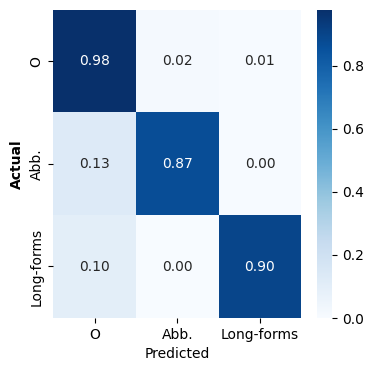

In [12]:
transformer_pipeline(dataset, "antoineedy/stanford-deidentifier-base-finetuned-ner")

#### Bert-NER base

In [13]:
transformer_pipeline(dataset, "antoineedy/bert-base-NER-finetuned-ner")

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### DistilGPT2

tokenizer_config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

  0%|          | 0/8 [00:00<?, ?it/s]

<Figure size 3840x2880 with 0 Axes>

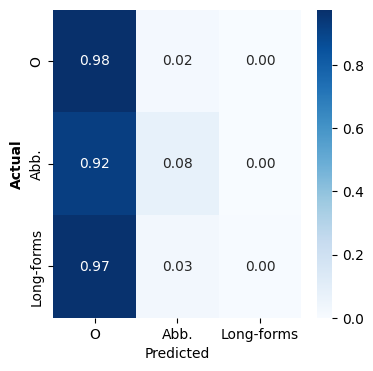

In [ ]:
transformer_pipeline(dataset, "antoineedy/distilgpt2-finetuned-ner")

#### DistilBert uncased

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

  0%|          | 0/8 [00:00<?, ?it/s]

<Figure size 3840x2880 with 0 Axes>

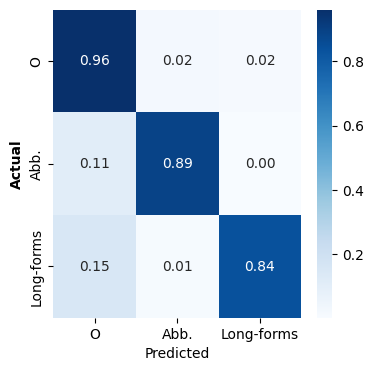

In [ ]:
transformer_pipeline(dataset,"antoineedy/distilbert-base-uncased-finetuned-ner")

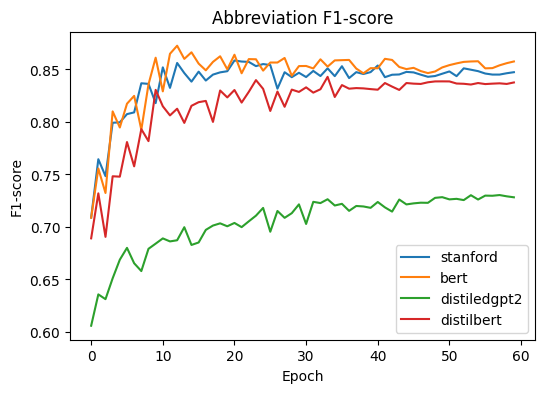

,Model,Abb. Precision,Abb. Recall,Abb. F1-score,LF Precision,LF Recall,LF F1-score,Weighted Avg F1-score
0,stanford,0.827,0.869,0.847,0.842,0.892,0.866,0.951
1,bert,0.803,0.920,0.858,0.785,0.817,0.801,0.929
2,distiledgpt2,0.613,0.897,0.728,0.467,0.627,0.535,0.866
3,distilbert,0.800,0.879,0.838,0.699,0.803,0.747,0.927


In [ ]:
tb_df = utils.from_tensorboard('tensorboard_runs/finetuned', isString=False)
tb_df.head()

### 2.3 Vectorization methods

#### Word2Vec

Emebdding matrix shape: torch.Size([8711, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.44      0.49      0.46       270
        I-LF       0.48      0.44      0.46       288
        B-LF       0.37      0.34      0.35       150
         B-O       0.92      0.92      0.92      4292

    accuracy                           0.85      5000
   macro avg       0.55      0.55      0.55      5000
weighted avg       0.85      0.85      0.85      5000



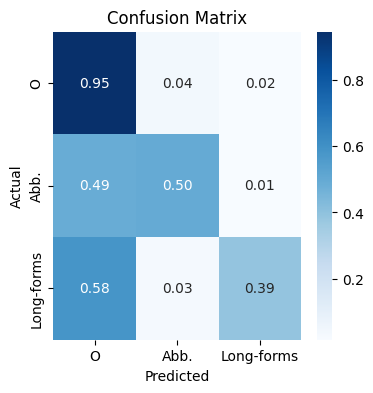

In [18]:
train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'word2vec')

output_path = "model_saves/word2vec"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

#### GloVe

Emebdding matrix shape: torch.Size([8711, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.57      0.72      0.64       270
        I-LF       0.62      0.85      0.72       288
        B-LF       0.50      0.67      0.57       150
         B-O       0.97      0.92      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.67      0.79      0.72      5000
weighted avg       0.92      0.90      0.90      5000



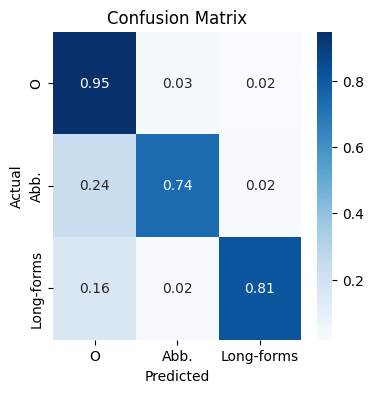

In [14]:
train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'glove')

output_path = "model_saves/glove"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

#### FastText

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.53      0.71      0.61       270
        I-LF       0.63      0.83      0.72       288
        B-LF       0.54      0.66      0.60       150
         B-O       0.97      0.92      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.67      0.78      0.72      5000
weighted avg       0.92      0.90      0.90      5000



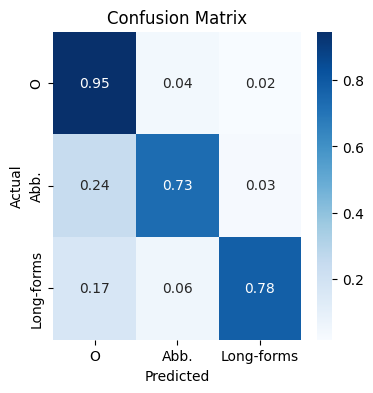

In [23]:
train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/fasttext_lem"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

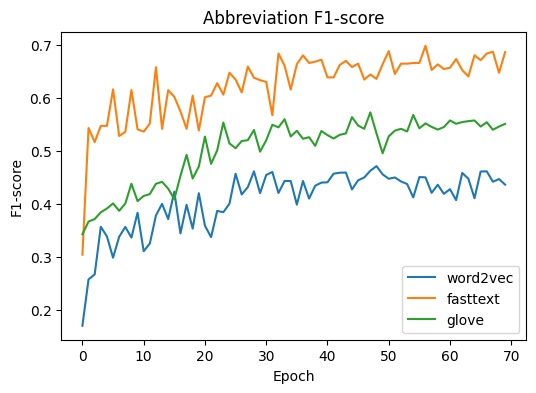

,Model,Abb. Precision,Abb. Recall,Abb. F1-score,LF Precision,LF Recall,LF F1-score,Weighted Avg F1-score
0,word2vec,0.477,0.403,0.437,0.438,0.329,0.375,0.859
1,fasttext,0.743,0.639,0.687,0.590,0.530,0.558,0.907
2,glove,0.505,0.608,0.552,0.565,0.523,0.544,0.899


In [17]:
tb_df = utils.from_tensorboard('tensorboard_runs/vectorization', isString=True)
tb_df.head()

### 2.4 Loss functions and optimizers

#### Hinge loss

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.37      0.73      0.49       270
        I-LF       0.57      0.75      0.65       288
        B-LF       0.44      0.64      0.52       150
         B-O       0.97      0.87      0.92      4292

    accuracy                           0.85      5000
   macro avg       0.59      0.75      0.65      5000
weighted avg       0.90      0.85      0.87      5000



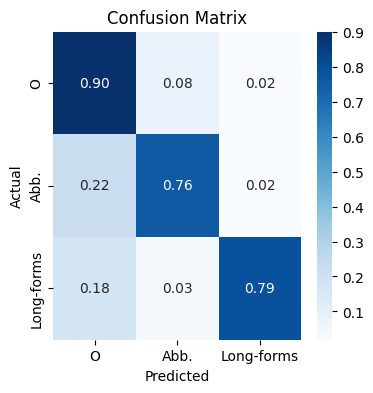

In [28]:
train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/hinge_loss"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

#### Cross-entropy

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.54      0.70      0.61       270
        I-LF       0.63      0.84      0.72       288
        B-LF       0.53      0.67      0.59       150
         B-O       0.97      0.92      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.67      0.78      0.71      5000
weighted avg       0.91      0.90      0.90      5000



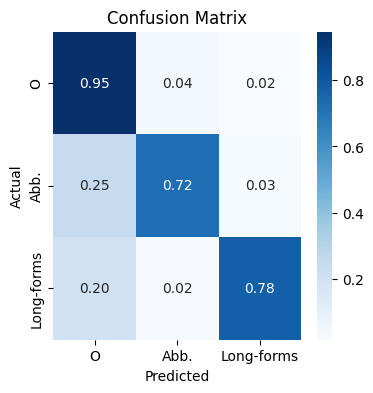

In [29]:
train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/fasttext_lem"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

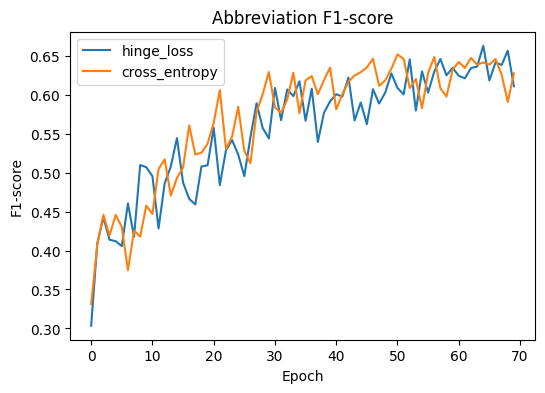

,Model,Abb. Precision,Abb. Recall,Abb. F1-score,LF Precision,LF Recall,LF F1-score,Weighted Avg F1-score
0,hinge_loss,0.514,0.753,0.611,0.484,0.617,0.543,0.891
1,cross_entropy,0.572,0.696,0.628,0.551,0.503,0.526,0.901


In [30]:
tb_df = utils.from_tensorboard('tensorboard_runs/loss_functions', isString=True)
tb_df.head()

#### SGD optimizer

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.27      0.84      0.40       270
        I-LF       0.57      0.81      0.66       288
        B-LF       0.49      0.59      0.54       150
         B-O       0.97      0.81      0.88      4292

    accuracy                           0.80      5000
   macro avg       0.57      0.76      0.62      5000
weighted avg       0.90      0.80      0.83      5000



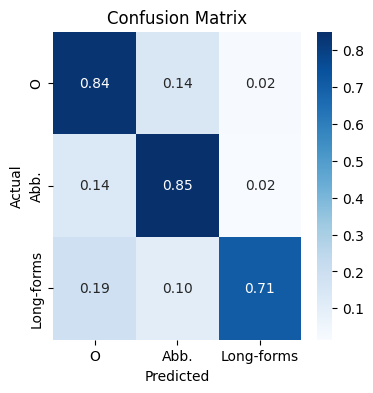

In [31]:
train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/sgd"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

#### Adam optimizer

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.26      0.80      0.39       270
        I-LF       0.62      0.75      0.68       288
        B-LF       0.54      0.63      0.58       150
         B-O       0.97      0.82      0.89      4292

    accuracy                           0.81      5000
   macro avg       0.60      0.75      0.64      5000
weighted avg       0.90      0.81      0.84      5000



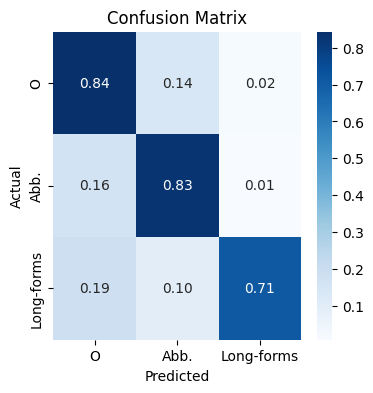

In [36]:
train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/adam"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

#### AdamW optimizer

Emebdding matrix shape: torch.Size([9135, 300])
Number of classes: 6 (['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF'])
              precision    recall  f1-score   support

        B-AC       0.54      0.69      0.60       270
        I-LF       0.64      0.85      0.73       288
        B-LF       0.51      0.65      0.57       150
         B-O       0.97      0.92      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.66      0.78      0.71      5000
weighted avg       0.92      0.90      0.90      5000



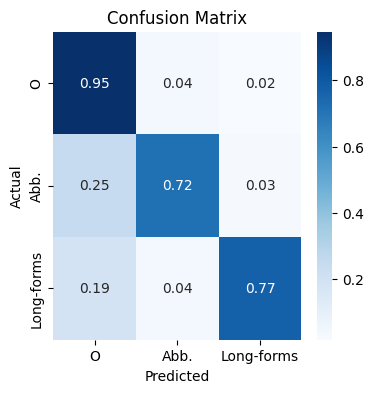

In [32]:
train_dataset = the_preprocess(dataset["train"], lematize=True)
test_dataset = the_preprocess(dataset["test"], lematize=True)
val_dataset = the_preprocess(dataset["validation"], lematize=True)

datasets = {
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
}

label_field, test_iter, BATCH_SIZE = bilstm_pipeline(datasets, 'fasttext')

output_path = "model_saves/fasttext_lem"
r = utils.results(output_path, label_field, test_iter, BATCH_SIZE)

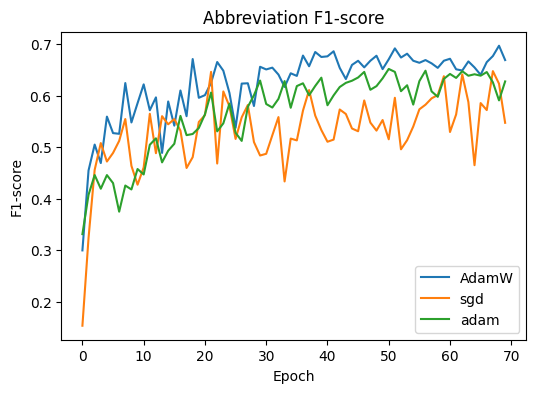

,Model,Abb. Precision,Abb. Recall,Abb. F1-score,LF Precision,LF Recall,LF F1-score,Weighted Avg F1-score
0,AdamW,0.694,0.646,0.669,0.593,0.490,0.537,0.913
1,sgd,0.398,0.878,0.547,0.450,0.604,0.516,0.867
2,adam,0.572,0.696,0.628,0.551,0.503,0.526,0.901


In [27]:
tb_df = utils.from_tensorboard('tensorboard_runs/optimizer', isString=True)
tb_df.head()

## 3. Results and comparisons

## 4. Analysis of the results

In [ ]:
# 5 random samples from the finetuned model

utils.show_visu(dataset, 'checkpoints/checkpoint-2000')

Output:  However , to what extent TCR - mediated signals determine identity and function of mature NKT cells remains incompletely understood .
Truth:   However , to what extent TCR - mediated signals determine identity and function of mature NKT cells remains incompletely understood . 

Output:  In low resource settings ( LRSs ) , treatment of neonatal jaundice is often sub - optimal [ 4 , 5 ] .
Truth:   In low resource settings ( LRSs ) , treatment of neonatal jaundice is often sub - optimal [ 4 , 5 ] . 

Output:  However , in some studies , we investigated the effects of gp120 on MDDC that were simultaneously induced to mature by other stimuli , notably lipopolysaccharide ( LPS ) .
Truth:   However , in some studies , we investigated the effects of gp120 on MDDC that were simultaneously induced to mature by other stimuli , notably lipopolysaccharide ( LPS ) . 

Output:  2A , left column , first and second row ) , in the anterior lateral bank of the IPS .
Truth:   2A , left column , f

## 5. Final evaluation